# Synchro Project
- [github link](https://github.com/romainmartinez/envergo)

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

# Figures
import matplotlib.pyplot as plt
import seaborn as sns

FIG_STYLE = Path('./fig_style.py')
if not FIG_STYLE.is_file():
    !wget --no-check-certificate --content-disposition https://github.com/romainmartinez/cookbook/raw/master/python/fig_style.py
from fig_style import get_style, show
plt.rcParams.update(get_style(style='mrtnz', figsize='two_col'))
palette = 'deep'

# to make this notebook's output stable across runs
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## Get data

In [2]:
DATA_PATH = Path('./data/zTable.xlsx')
df = pd.read_excel(DATA_PATH)

In [3]:
# athletes' name
names = df['name']
# variables
variables = [
    'ADD/G', 'ADD/D', 'ABD/G', 'ABD/D', 'ER/G', 'ER/D', 'IR/G', 'IR/D',
    'EXT/G', 'EXT/D', 'FLEX/G', 'FLEX/D'
]
X = df[variables] / 9.81
# targets
targets = ['Body-boost', 'Egg-beater max height', 'Egg-beater max force']
y = df[targets]
# not included: 'DYN SD', 'EGG MIN ', 'EGG SD', 'EGG MAX-MIN'
X.head()

,ADD/G,ADD/D,ABD/G,ABD/D,ER/G,ER/D,IR/G,IR/D,EXT/G,EXT/D,FLEX/G,FLEX/D
0,29.260958,29.051988,21.085627,18.338430,9.464832,9.678899,5.331295,5.295617,16.987768,20.050968,18.654434,14.882773
1,29.841998,30.861366,24.449541,21.187564,11.136595,10.524975,10.030581,8.567788,31.396534,26.243629,15.963303,12.573904
2,25.728848,26.355759,23.797146,23.817533,7.064220,7.013252,12.232416,12.212029,14.383282,11.539246,20.341488,20.876656
3,21.758410,23.180428,17.737003,13.465851,5.524975,5.749235,4.067278,3.792049,14.123344,0.203874,12.003058,11.442406
4,28.720693,30.193680,26.365953,23.165138,9.913354,10.096840,7.869521,6.365953,21.116208,17.018349,16.156983,15.581040


### Normalize data
We should normalize the groin bar tests (`X`) by anthropometric measurements.

In [4]:
NORMALIZE = False
if NORMALIZE:
#     normalizer = df['Weight'] / (df['Height'] * df['Height'])
#     normalizer = df['Weight'] * df['Height']
    normalizer = df['Weight']
    X = X.divide(normalizer, axis=0)

### nan remover

In [5]:
nan_id = np.argwhere(np.isnan(X.values))
for i in nan_id:
    print(f'participant no.: {i[0]}')
    print(f'\ttest: {X.columns[i[1]]}')
    # if left take right, left otherwise
    if X.columns[i[1]][-1] == 'G':
        replacer = i[1] + 1
    else:
        replacer = i[1] - 1
    print(f'\t\t"{X.iloc[i[0], i[1]]}" replace by "{X.iloc[i[0], replacer]}"')
    X.at[i[0], X.columns[i[1]]] = X.at[i[0], X.columns[replacer]]

participant no.: 5
	test: ADD/D
		"nan" replace by "32.95107033639144"
participant no.: 41
	test: IR/G
		"nan" replace by "12.125382262996942"
participant no.: 90
	test: IR/G
		"nan" replace by "9.403669724770642"


### X description
- `ADD`: adduction test
- `ABD`: abduction test
- `ER`: external rotation test
- `IR`: internal rotation test
- `EXT`: extension test
- `FLEX`: flexion test




In [6]:
X.head()

,ADD/G,ADD/D,ABD/G,ABD/D,ER/G,ER/D,IR/G,IR/D,EXT/G,EXT/D,FLEX/G,FLEX/D
0,29.260958,29.051988,21.085627,18.338430,9.464832,9.678899,5.331295,5.295617,16.987768,20.050968,18.654434,14.882773
1,29.841998,30.861366,24.449541,21.187564,11.136595,10.524975,10.030581,8.567788,31.396534,26.243629,15.963303,12.573904
2,25.728848,26.355759,23.797146,23.817533,7.064220,7.013252,12.232416,12.212029,14.383282,11.539246,20.341488,20.876656
3,21.758410,23.180428,17.737003,13.465851,5.524975,5.749235,4.067278,3.792049,14.123344,0.203874,12.003058,11.442406
4,28.720693,30.193680,26.365953,23.165138,9.913354,10.096840,7.869521,6.365953,21.116208,17.018349,16.156983,15.581040


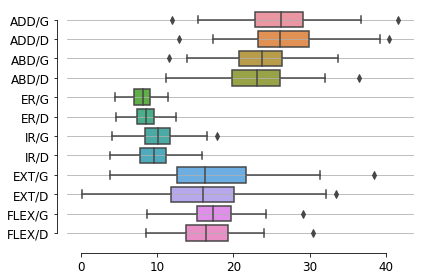

In [7]:
sns.boxplot(data=X, orient='h')
plt.grid(axis='y')
show()

### y description
- `EGG MEAN`: mean eggbeater score
- `EGG MAX`: max. eggbeater score
- `BODYBOOST`: bodyboost score
- `DYN MEAN`: mean dynamometer force
- `DYN MAX`: max. dynamometer force

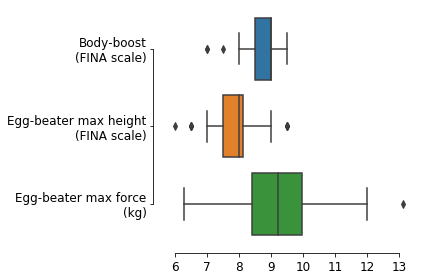

In [8]:
fig, ax = plt.subplots()
sns.boxplot(data=y, orient='h')

ax.set_yticklabels(['Body-boost\n(FINA scale)', 'Egg-beater max height\n(FINA scale)', 'Egg-beater max force\n(kg)'])
show(save='share/fig/y.png')

## Add features

### Fscore
Let's try to transform each *left* and *right* tests into a single "Fscore" such as:
$$F_{\text{score}} = 2 \times \frac{\text{left} \times \text{right}}{\text{left} + \text{right}}$$

This formula favors left & right tests that are similar and therefore penalizes asymmetries.

In [9]:
def f_score(a, b):
    """Takes two columns and compute the F score."""
    return 2 * (a * b) / (a + b)

### Imbalance
Let's try to compute the *imbalance* score for each test, such as:
$$\text{imbalance} = |\frac{\text{left} - \text{right}}{\text{left}}| * 100$$

In [10]:
def imbalance(a, b):
    """compute the imbalance score, in percentage."""
    return np.abs((a - b) / a) * 100

In [11]:
X_augmented = pd.DataFrame()
for name, icol in X.iteritems():
    b = np.empty(0)
    if name[-1] == 'G':
        a = icol
    else:
        b = icol
    if b.any():
        X_augmented[name[:-2]] = f_score(a, b)
        X_augmented[f'imb_{name[:-2]}'] = imbalance(a, b)

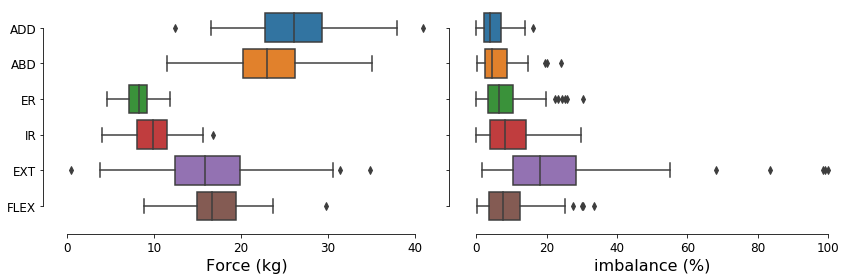

In [12]:
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(12, 4))

sns.boxplot(
    data=X_augmented[[i for i in X_augmented if i[0] == 'i']],
    orient='h',
    ax=ax[1])
sns.boxplot(
    data=X_augmented[[i for i in X_augmented if i[0] != 'i']],
    orient='h',
    ax=ax[0])

ax[0].set_xlabel('Force (kg)')

ax[1].set_xlabel('imbalance (%)')

show(save='share/fig/X.png')

### Add height and/or weight

In [13]:
X_augmented['Height'] = df['Height']
X_augmented['Weight'] = df['Weight']

## Fitting an ensemble model

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_augmented, y, test_size=0.2, random_state=RANDOM_SEED)

### Helper functions

In [15]:
from sklearn.metrics import mean_squared_error


def mape(y_test, y_pred):
    return (np.abs((y_test - y_pred) / y_test)) * 100


def rmse(y_test, y_pred):
    return np.sqrt(((y_test - y_pred)**2))


def evaluate(y_test, y_pred):
    d = {'rmse': rmse(y_test, y_pred), 'mape': mape(y_test, y_pred)}
    print(f"""
    \trmse = {d['rmse'].mean():.3f} ({d['rmse'].std():.3f})
    \tmape = {d['mape'].mean():.3f}% ({d['mape'].std():.3f})
    """)
    return d

In [16]:
from skopt import BayesSearchCV, dump, load

class BayesSearch:
    def __init__(self, model, search_spaces, n_iter, export_path):
        self.export_path = export_path
        self.bayes_cv_tuner = BayesSearchCV(
            model,
            search_spaces,
            cv=5,
            n_jobs=-1,
            n_iter=n_iter,
            verbose=0,
            refit=True,
            
            random_state=RANDOM_SEED)

    def fit(self, X, y):
        self.bayes_cv_tuner.fit(X, y, callback=self.print_status)
        self.export_results()

    def print_status(self, optim_results):
        print(f"""
Model #{len(opt.bayes_cv_tuner.cv_results_['params'])}
Best: {self.bayes_cv_tuner.best_score_}
Best params: {self.bayes_cv_tuner.best_params_}
        """)

    def export_results(self):
        pd.DataFrame(self.bayes_cv_tuner.cv_results_).to_csv(
            f'{self.export_path}_cv_results.csv')
        pd.Series(self.bayes_cv_tuner.best_params_).to_json(
            f'{self.export_path}_best_params.json')
        dump(self.bayes_cv_tuner, f'{self.export_path}_bayes_search.pkl')

/home/romain/miniconda3/envs/synchro/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Optimized model

In [17]:
from xgboost import XGBRegressor

OPT = False
ITERATIONS = 100

params = {'n_jobs': 1, 'silent': 1, 'tree_method': 'approx'}

if OPT:
    for itarget in targets:
        OPT_EXPORT = f'opt/{itarget}'

        search_spaces = {
            'learning_rate': (0.01, 1.0, 'log-uniform'),
            'min_child_weight': (0, 10),
            'max_depth': (0, 50),
            'max_delta_step': (0, 20),
            'subsample': (0.01, 1.0, 'uniform'),
            'colsample_bytree': (0.01, 1.0, 'uniform'),
            'colsample_bylevel': (0.01, 1.0, 'uniform'),
            'reg_lambda': (1e-9, 1000, 'log-uniform'),
            'reg_alpha': (1e-9, 1.0, 'log-uniform'),
            'gamma': (1e-9, 0.5, 'log-uniform'),
            'min_child_weight': (0, 5),
            'n_estimators': (50, 100),
            'scale_pos_weight': (1e-6, 500, 'log-uniform')
        }

        opt = BayesSearch(
            model=XGBRegressor(**params),
            search_spaces=search_spaces,
            n_iter=ITERATIONS,
            export_path=OPT_EXPORT)
        opt.fit(X_train, y_train[itarget])

In [18]:
USE_OPT = False

boosted = {}
evaluation = {}

for itarget, itarget_name in enumerate(targets):
    print(f'\t{itarget}. {itarget_name}\n')

    opt_params = load(f'opt/{itarget_name}_bayes_search.pkl').best_params_ if USE_OPT else {}

    boosted[itarget_name] = XGBRegressor(
        **{
            **params,
            **opt_params
        }, random_state=RANDOM_SEED)
    boosted[itarget_name].fit(
        X_train,
        y_train[itarget_name],
        eval_set=[(X_train, y_train[itarget_name]), (X_test,
                                                     y_test[itarget_name])],
        early_stopping_rounds=50,
        eval_metric='rmse',
        verbose=50)

    evaluation[itarget_name] = evaluate(y_test[itarget_name],
                                        boosted[itarget_name].predict(X_test))
    evaluation[itarget_name]['test'] = [
        itarget_name for i in range(len(evaluation[itarget_name]['rmse']))
    ]

    print(f'{"-" * 30}\n')
evaluation = pd.concat([pd.DataFrame(evaluation[itest]) for itest in evaluation.keys()])

	0. Body-boost

[17:24:08] Tree method is selected to be 'approx'
[0]	validation_0-rmse:7.41009	validation_1-rmse:7.61465
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[50]	validation_0-rmse:0.200503	validation_1-rmse:0.567182
[99]	validation_0-rmse:0.070975	validation_1-rmse:0.525167

    	rmse = 0.457 (0.265)
    	mape = 5.122% (2.926)
    
------------------------------

	1. Egg-beater max height

[17:24:08] Tree method is selected to be 'approx'
[0]	validation_0-rmse:6.69379	validation_1-rmse:6.52258
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[50]	validation_0-rmse:0.210686	validation_1-rmse:0.744923
[99]	validation_0-rmse:0.057215	validation_1-rmse:0.747745

    	rmse = 0.624 (0.403)
    	mape = 8.540% (6.570)
    
------------------------------

	2. Egg-b

In [19]:
evaluation.groupby(['test']).mean().sum()

rmse     2.310233
mape    26.158632
dtype: float64

/home/romain/miniconda3/envs/synchro/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


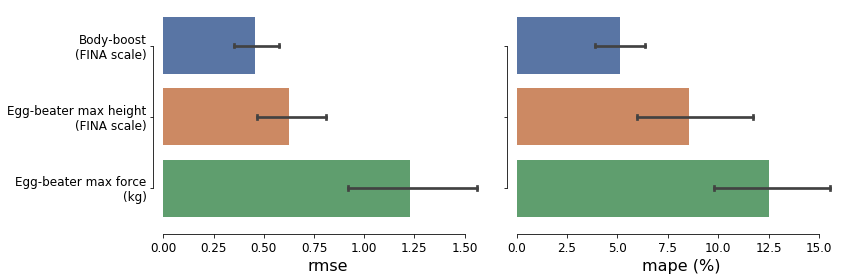

In [20]:
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(12, 4))
sns.barplot(y='test', x='rmse', data=evaluation, capsize=0.05, ax=ax[0], orient='h', palette=palette)
sns.barplot(y='test', x='mape', data=evaluation, capsize=0.05, ax=ax[1], orient='h', palette=palette)
ax[0].set_ylabel('')
ax[1].set_ylabel('')
ax[1].set_xlabel('mape (%)')
# TODO: %

ax[0].set_yticklabels(['Body-boost\n(FINA scale)', 'Egg-beater max height\n(FINA scale)', 'Egg-beater max force\n(kg)'])

show(save='share/fig/evaluation.png')

## Interpretation

In [21]:
import shap
shap.initjs()

explainer = {itarget: shap.TreeExplainer(boosted[itarget]) for itarget in targets}
shap_values = {itarget: explainer[itarget].shap_values(X_augmented) for itarget in targets}

### How important are our features?
To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample.

The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output.

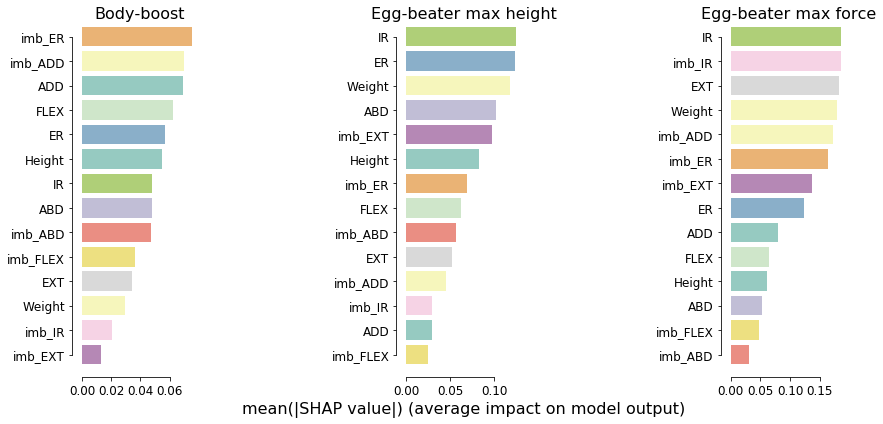

In [22]:
ORDER = True
sharey = False if ORDER else True
palette = 'Set3'
fig, ax = plt.subplots(ncols=3, sharey=sharey, figsize=(12, 6))

rgb_values = sns.color_palette(palette, len(X_augmented.columns))
color_map = dict(zip(X_augmented.columns, rgb_values))
feature_importance = {}

for i, itarget in enumerate(targets):
    shap_df = pd.DataFrame(
        shap_values[itarget], columns=X_augmented.columns).abs()
    if ORDER:
        feature_importance[itarget] = shap_df.mean().sort_values(ascending=False).index
        color = [color_map[i] for i in shap_df.mean().sort_values(ascending=False).index]
    else:
        order = None
        color = sns.color_palette(palette, len(shap_df.columns))

    sns.barplot(
        data=shap_df,
        orient='h',
        order=feature_importance[itarget],
        ci=None,
        palette=color,
        ax=ax[i])
    ax[i].set_title(itarget)
    
    if i == 1:
        ax[i].set_xlabel('mean(|SHAP value|) (average impact on model output)')
    
show()

/home/romain/miniconda3/envs/synchro/lib/python3.6/site-packages/matplotlib/colorbar.py:217: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


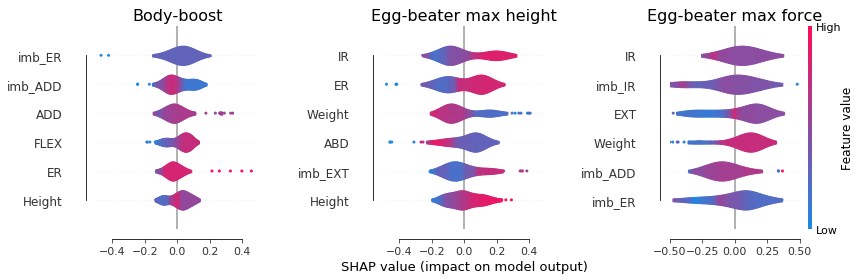

In [23]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
MAX_DISPLAY = 6

for i, itarget in enumerate(targets):
    color_bar = True if i == 2 else False

    plt.sca(ax[i])
    shap.summary_plot(
        shap_values[itarget],
        X_augmented,
        show=False,
        color_bar=color_bar,
        auto_size_plot=False,
        max_display=MAX_DISPLAY,
        plot_type='violin')
    ax[i].set_title(itarget)
    ax[i].set_xlim(-0.5, 0.5)
    if i != 1:
        ax[i].set_xlabel('')
show(save='share/fig/features_importance.pdf')

### What is the prediction path?
The below explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output.

Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

In [24]:
random_observation = np.random.randint(0, X_augmented.shape[0])

itarget = targets[0]

shap.force_plot(explainer[itarget].expected_value,
                shap_values[itarget][random_observation, :],
                X_augmented.iloc[random_observation, :])

If we take many explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally, we can see explanations for an entire dataset

In [25]:
shap.force_plot(explainer[itarget].expected_value, shap_values[itarget], X_augmented)

In [26]:
itarget = targets[1]

shap.force_plot(explainer[itarget].expected_value,
                shap_values[itarget][random_observation, :],
                X_augmented.iloc[random_observation, :])

In [27]:
shap.force_plot(explainer[itarget].expected_value, shap_values[itarget], X_augmented)

In [28]:
itarget = targets[2]

shap.force_plot(explainer[itarget].expected_value,
                shap_values[itarget][random_observation, :],
                X_augmented.iloc[random_observation, :])

In [29]:
shap.force_plot(explainer[itarget].expected_value, shap_values[itarget], X_augmented)

### How is target variable related with important features?
The XGBoost model we trained above is very complicated, but by plotting the SHAP value for a feature against the actual value of the feature for all observations we can see how changes in the feature's value effect the model's output.

To understand how a single feature effects the output of the model we can plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset.

Since SHAP values represent a feature's responsibility for a change in the model output, the plot below represents the change in fatigue as AveShEleMean changes.

Vertical dispersion at a single value of AveShEleMean represents interaction effects with other features.

To help reveal these interactions dependence_plot automatically selects another feature for coloring.

In this case coloring by ROMTrYMean highlights that AveShEleMean has less impact on fatigue when ROMTrXMean decreases and conversely.

/home/romain/miniconda3/envs/synchro/lib/python3.6/site-packages/matplotlib/colorbar.py:217: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")
/home/romain/miniconda3/envs/synchro/lib/python3.6/site-packages/matplotlib/colorbar.py:217: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")
/home/romain/miniconda3/envs/synchro/lib/python3.6/site-packages/matplotlib/colorbar.py:217: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")
/home/romain/miniconda3/envs/synchro/lib/python3.6/site-packages/matplotlib/colorbar.py:217: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")
/home/romain/miniconda3/envs/synchro/lib/python3.6/site-packages/matplotlib/colorbar.py:217: UserWarning: Use the colorbar set_ticks() metho

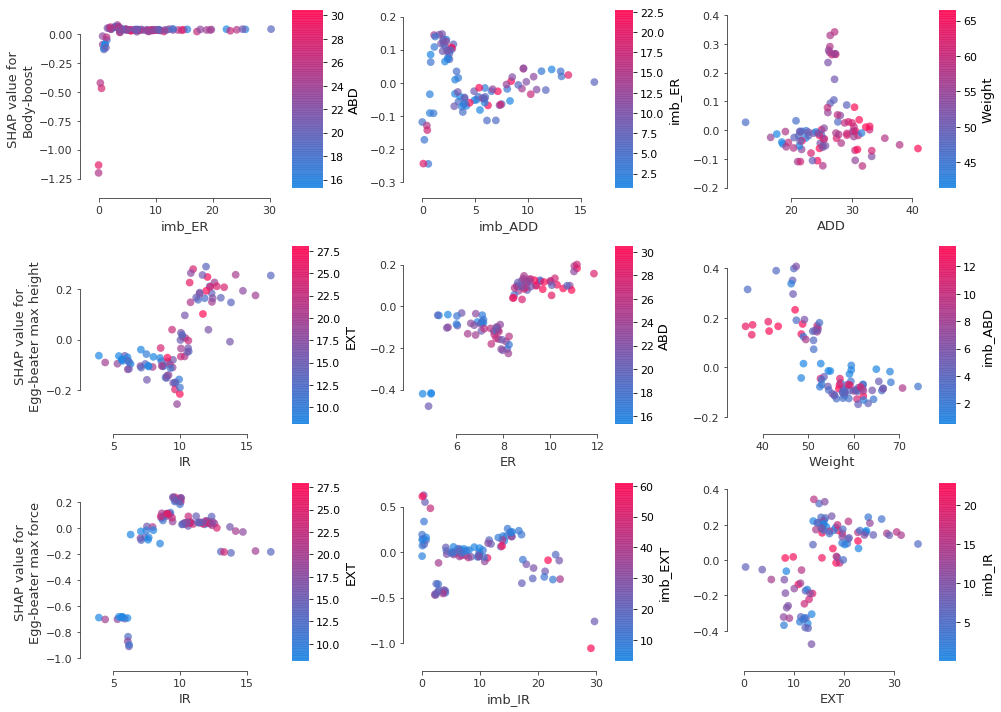

In [30]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 4))

for irow, itarget in enumerate(targets):
    # sort the features indexes by their importance in the model
    # (sum of SHAP value magnitudes over the validation dataset)
    top_inds = np.argsort(-np.sum(np.abs(shap_values[itarget]), axis=0))

    # make SHAP plots of the three most important features and their best interaction
    for icol, idx in enumerate(top_inds[:3]):
        plt.sca(ax[irow, icol])

        shap.dependence_plot(
            idx,
            shap_values[itarget],
            X_augmented,
            dot_size=60,
            alpha=.7,
            show=False)
        ax[irow, icol].set_ylabel('')
    ax[irow, 0].set_ylabel(f'SHAP value for\n{itarget}')

plt.gcf().set_size_inches(14, 10)
show()

### Supervised clustering
Clustering people by their shap values leads to groups relevent to the prediction task at hand.

In [31]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
itarget = targets[0]

shap_pca2 = PCA(n_components=2).fit_transform(shap_values[itarget][:, :-1])
shap_embedded = TSNE(
    n_components=2, perplexity=50).fit_transform(shap_values[itarget][:, :-1])

In [32]:
def plot_clusters(x, y, c, label, a):
    a.scatter(
        x, y, c=c, linewidth=0, alpha=0.8, cmap=shap.plots.colors.red_blue, s=60)
    PCM=a.get_children()[0]
    cb = plt.colorbar(PCM, label=label, aspect=40, orientation="horizontal", ax=a)
    cb.set_alpha(1)
    cb.draw_all()
    cb.outline.set_linewidth(0)
    cb.ax.tick_params('x', length=0)
    cb.ax.xaxis.set_label_position('top')
    a.axis("off")

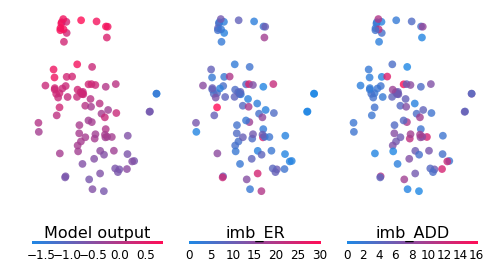

In [33]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(8,5))

plot_clusters(
    x=shap_embedded[:, 0],
    y=shap_embedded[:, 1],
    c=np.sum(shap_values[itarget], axis=1),
    a=ax[0],
    label='Model output')

plot_clusters(
    x=shap_embedded[:, 0],
    y=shap_embedded[:, 1],
    c=X_augmented[feature_importance[itarget][0]],
    a=ax[1],
    label=feature_importance[itarget][0])

plot_clusters(
    x=shap_embedded[:, 0],
    y=shap_embedded[:, 1],
    c=X_augmented[feature_importance[itarget][1]],
    a=ax[2],
    label=feature_importance[itarget][1])

plt.show()

## Sensitivity Analysis

### What is the impact of a 5% increase of each variable on the target variable?

In [34]:
def simulate(row, m, var, perc, ax, legend, title):
    row = row.copy()
    baseline = m.predict(row)
    plus = {}

    for ivar in var:
        X_plus = row.copy()
        X_plus[ivar] = X_plus[ivar] + X_plus[ivar] * (perc / 100)
        plus[ivar] = m.predict(X_plus)

    radar = pd.DataFrame(plus, index=[f'+{perc}%'])
    radar.loc['raw'] = np.repeat(baseline, radar.shape[1])
    plot_radar(radar.reset_index(), ax, legend, title)


def plot_radar(r, ax, legend, title):
    categories = r.columns[1:]
    N = categories.shape[0]
    
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)

    ax.set_rlabel_position(0)
    mini = int(r.min(axis=1).min()) - 2
    maxi = int(r.max(axis=1).max()) + 2
    target_range = np.arange(mini, maxi)
    ax.set_yticks(target_range)
    ax.set_yticklabels([str(i) for i in target_range], color="grey", size=10)
    ax.set_ylim(target_range[0], target_range[-1])

    values = r.loc[0].drop('index').values.flatten().tolist()
    values += values[:1]
    ax.plot(
        angles,
        values,
        linewidth=2,
        linestyle='-',
        color='#3498db',
        label=r.loc[0]['index'])
    ax.fill(angles, values, '#3498db', alpha=0.1)
    

    values = r.loc[1].drop('index').values.flatten().tolist()
    values += values[:1]
    ax.plot(
        angles,
        values,
        linewidth=2,
        linestyle='-',
        color='grey',
        label=r.loc[1]['index'])
#     ax.fill(angles, values, 'grey', alpha=0.5)
    
    ax.set_title(title, y=1.2)
    if legend: ax.legend(loc='upper right', bbox_to_anchor=[1.5, .6])

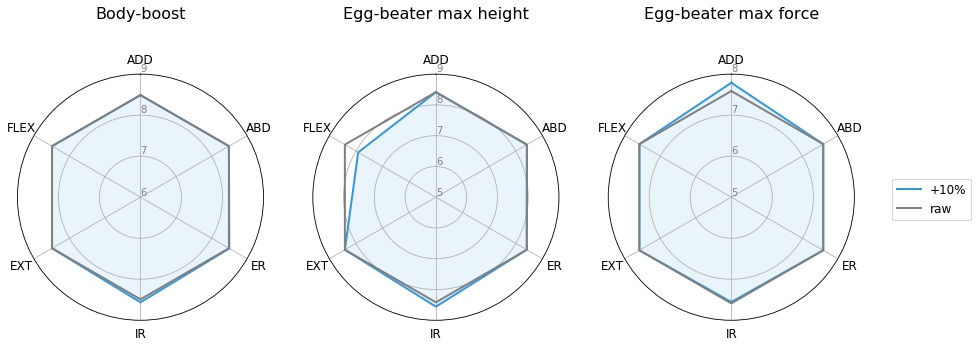

In [35]:
var = ['ADD', 'ABD', 'ER', 'IR', 'EXT', 'FLEX']
perc = 10

fig, ax = plt.subplots(
    ncols=3, figsize=(15, 5), subplot_kw=dict(projection='polar'))
for i, itarget in enumerate(targets):
    legend = True if i == 2 else False
    simulate(
        row=X_augmented.iloc[[42]],
        m=boosted[itarget],
        var=var,
        perc=perc,
        ax=ax[i],
        title=itarget,
        legend=legend)

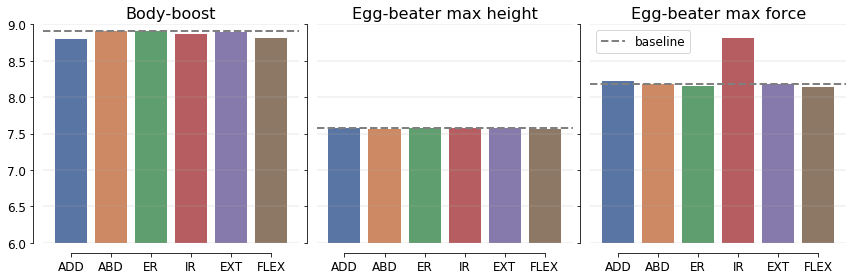

In [36]:
class Simulate:
    def __init__(self, obs, models, var):
        self.obs = obs
        self.models = models
        self.var = var

    def simulate_increase(self, percentage):
        df_simulation = pd.DataFrame()
        for itarget, itarget_model in self.models.items():
            df_simulation = pd.concat([
                df_simulation,
                self.target_increase(itarget, itarget_model, percentage)
            ])
        return df_simulation

    def target_increase(self, target, model, percentage):
        baseline = model.predict(self.obs)
        plus = {}
        for ivar in self.var:
            X_plus = self.obs.copy()
            X_plus[ivar] = X_plus[ivar] + X_plus[ivar] * (percentage / 100)
            plus[ivar] = model.predict(X_plus)
        b = pd.DataFrame(
            plus, index=['simulated'
                         ]).T.reset_index().rename(columns={'index': 'test'})
        b['baseline'] = baseline[0]
        b['diff'] = b.apply(
            lambda x: self.relative_diff(x['baseline'], x['simulated']),
            axis=1)
        b['target'] = target
        return b

    @staticmethod
    def plot_simulation(d):
        fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(12, 4))

        for i, itarget in enumerate(targets):
            sub = d[d['target'] == itarget]
            sns.barplot(x='test', y='simulated', data=sub, palette='deep', ax=ax[i])
            ax[i].axhline(sub['baseline'].values[0], color='grey', linestyle='--', linewidth=2)
            ax[i].plot([0, 0], [-100, -100], color='grey', linestyle='--', linewidth=2, label='baseline')
            if i == 2: ax[i].legend()

            if i == 0:
                maxi = int(d['simulated'].max() + d['simulated'].max() * 0.1)
                mini = int(d['simulated'].min() - d['simulated'].min() * 0.1)
                ax[i].set_ylim([mini, maxi])

            ax[i].set_title(itarget)
            ax[i].set_xlabel('')
            ax[i].set_ylabel('')
            ax[i].grid(axis='y', linewidth=.3)
        show()

    @staticmethod
    def relative_diff(b, s):
        return ((s - b) / s) * 100


VAR = ['ADD', 'ABD', 'ER', 'IR', 'EXT', 'FLEX']
# VAR = [f'imb_{i}' for i in VAR]
PERC = 20
ROW = X_augmented.iloc[[29]]

S = Simulate(obs=ROW, models=boosted, var=VAR)
d = S.simulate_increase(PERC)
S.plot_simulation(d)

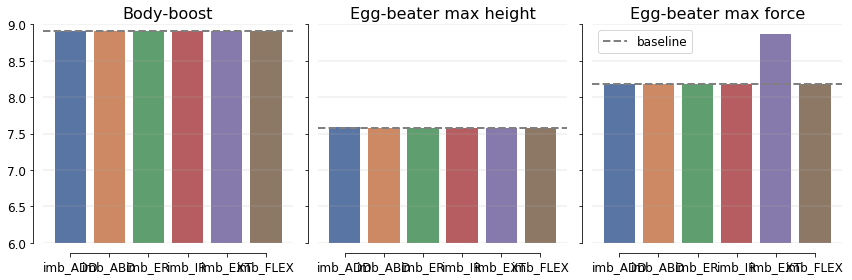

In [37]:
class Simulate:
    def __init__(self, obs, models, var):
        self.obs = obs
        self.models = models
        self.var = var

    def simulate_increase(self, percentage):
        df_simulation = pd.DataFrame()
        for itarget, itarget_model in self.models.items():
            df_simulation = pd.concat([
                df_simulation,
                self.target_increase(itarget, itarget_model, percentage)
            ])
        return df_simulation

    def target_increase(self, target, model, percentage):
        baseline = model.predict(self.obs)
        plus = {}
        for ivar in self.var:
            X_plus = self.obs.copy()
            X_plus[ivar] = X_plus[ivar] + X_plus[ivar] * (percentage / 100)
            plus[ivar] = model.predict(X_plus)
        b = pd.DataFrame(
            plus, index=['simulated'
                         ]).T.reset_index().rename(columns={'index': 'test'})
        b['baseline'] = baseline[0]
        b['diff'] = b.apply(
            lambda x: self.relative_diff(x['baseline'], x['simulated']),
            axis=1)
        b['target'] = target
        return b

    @staticmethod
    def plot_simulation(d):
        fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(12, 4))

        for i, itarget in enumerate(targets):
            sub = d[d['target'] == itarget]
            sns.barplot(x='test', y='simulated', data=sub, palette='deep', ax=ax[i])
            ax[i].axhline(sub['baseline'].values[0], color='grey', linestyle='--', linewidth=2)
            ax[i].plot([0, 0], [-100, -100], color='grey', linestyle='--', linewidth=2, label='baseline')
            if i == 2: ax[i].legend()

            if i == 0:
                maxi = int(d['simulated'].max() + d['simulated'].max() * 0.1)
                mini = int(d['simulated'].min() - d['simulated'].min() * 0.1)
                ax[i].set_ylim([mini, maxi])

            ax[i].set_title(itarget)
            ax[i].set_xlabel('')
            ax[i].set_ylabel('')
            ax[i].grid(axis='y', linewidth=.3)
            for item in ax[i].get_xticklabels():
                item.set_rotation(45)
        show()

    @staticmethod
    def relative_diff(b, s):
        return ((s - b) / s) * 100


VAR = ['ADD', 'ABD', 'ER', 'IR', 'EXT', 'FLEX']
VAR = [f'imb_{i}' for i in VAR]
PERC = 20
ROW = X_augmented.iloc[[29]]

S = Simulate(obs=ROW, models=boosted, var=VAR)
d = S.simulate_increase(PERC)
S.plot_simulation(d)

In [38]:
itarget = 'Body-boost'
d[d['target'] == itarget]['simulated'].max()

8.903702

### How to improve by 0.5 on the FINA scale with the minimum force increase?

In [56]:
def augment_X(X):
    X_augmented = pd.DataFrame()
    for name, icol in X.iteritems():
        b = np.empty(0)
        if name[-1] == 'G':
            a = icol
        else:
            b = icol
        if b.any():
            X_augmented[name[:-2]] = f_score(a, b)
            X_augmented[f'imb_{name[:-2]}'] = imbalance(a, b)

    X_augmented['Height'] = df['Height']
    X_augmented['Weight'] = df['Weight']
    return X_augmented


def f(x, force_initial=force_initial, score_initial=score_initial):
    row = augment_X(x + force_initial)
    return x.sum() + (model.predict(row) - score_initial - 0.5) * 1000

In [57]:
participant = 42
target = 'Body-boost'
force_initial = X.iloc[[participant]]
row = augment_X(force_initial)
model = boosted[target]
score_initial = model.predict(row)

In [58]:
force_initial

,ADD/G,ADD/D,ABD/G,ABD/D,ER/G,ER/D,IR/G,IR/D,EXT/G,EXT/D,FLEX/G,FLEX/D
42,20.59633,22.324159,16.37105,16.615698,6.37105,8.012232,9.643221,9.255861,20.066259,17.456677,12.956167,11.962283


In [86]:
import pygmo as pg

# 1 - Instantiate a pygmo problem constructing it from a UDP
# (user defined problem).
prob = pg.problem(pg.schwefel(30))

# 2 - Instantiate a pagmo algorithm
algo = pg.algorithm(pg.sade(gen=100))

# 3 - Instantiate an archipelago with 16 islands having each 20 individuals
archi = pg.archipelago(16, algo=algo, prob=prob, pop_size=20)

# 4 - Run the evolution in parallel on the 16 separate islands 10 times.
archi.evolve(20)

# 5 - Wait for the evolutions to be finished
archi.wait()

# 6 - Print the fitness of the best solution in each island
res = [isl.get_population().champion_f for isl in archi]
print(res)

[array([1.56505848e-08]), array([2.33245373e-07]), array([1.98426278e-07]), array([1.88116246e-07]), array([1.5041951e-07]), array([1.67327016e-07]), array([2.76286301e-08]), array([2.72300895e-07]), array([1.10185283e-07]), array([1.48938852e-07]), array([3.10430551e-07]), array([2.82678229e-07]), array([1.33884896e-07]), array([2.84822818e-07]), array([1.09988832e-07]), array([118.43833476])]


In [88]:
prob

Problem name: Schwefel Function
	Global dimension:			30
	Integer dimension:			0
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [-500, -500, -500, -500, -500, ... ]
	Upper bounds: [500, 500, 500, 500, 500, ... ]

	Has gradient: false
	User implemented gradient sparsity: false
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0

	Thread safety: basic

In [92]:
from pygmo import problem

class my_problem(problem):
    """
    De Jong (sphere) function implemented purely in Python.

    USAGE: my_problem(dim=10)

    * dim problem dimension
    """

    def __init__(self, dim=10):
        # First we call the constructor of the base class telling PyGMO
        # what kind of problem to expect ('dim' dimensions, 1 objective, 0 contraints etc.)
        super(my_problem,self).__init__(dim)

        # We set the problem bounds (in this case equal for all components)
        self.set_bounds(-5.12, 5.12)

    # Reimplement the virtual method that defines the objective function.
    def _objfun_impl(self, x):

        # Compute the sphere function
        f = sum([x[i] ** 2 for i in range(self.dimension)])

        # Note that we return a tuple with one element only. In PyGMO the objective functions
        # return tuples so that multi-objective optimization is also possible.
        return (f, )

    # Finally we also reimplement a virtual method that adds some output to the __repr__ method
    def human_readable_extra(self):
        return "\n\t Problem dimension: " + str(self.__dim)

In [100]:
class sphere_function:
def __init__(self, dim):
         self.dim = dim

     def fitness(self, x):
         return [sum(x*x)]

    def get_bounds(self):
         return ([-1] * self.dim, [1] * self.dim)

     def get_name(self):
        return "Sphere Function"

     def get_extra_info(self):
        return "\tDimensions: " + str(self.dim)

In [94]:
import pygmo as pg

# 1 - Instantiate a pygmo problem constructing it from a UDP
# (user defined problem).
prob = pg.problem(pg.schwefel(30))

# 2 - Instantiate a pagmo algorithm
algo = pg.algorithm(pg.sade(gen=100))

# 3 - Instantiate an archipelago with 16 islands having each 20 individuals
archi = pg.archipelago(16, algo=algo, prob=prob, pop_size=20)

# 4 - Run the evolution in parallel on the 16 separate islands 10 times.
archi.evolve(20)

# 5 - Wait for the evolutions to be finished
archi.wait()

# 6 - Print the fitness of the best solution in each island
res = [isl.get_population().champion_f for isl in archi]
print(res)

[array([2.70163582e-07]), array([1.46497769e-07]), array([2.89555828e-07]), array([118.43833472]), array([2.12523446e-07]), array([1.05710569e-07]), array([1.90855644e-07]), array([1.03338607e-07]), array([1.48069375e-07]), array([2.77967047e-07]), array([1.86739271e-07]), array([2.60284651e-07]), array([2.63977199e-07]), array([1.52356733e-07]), array([3.34654032e-07]), array([2.2232598e-07])]


## Test PDP

In [147]:
from pdpbox import pdp, info_plots

feature = 'imb_ADD'
target = 'Body-boost'

df_pdp = X_augmented.copy()
df_pdp[target] = y[target]

### Target distribution through feature 'ADD'

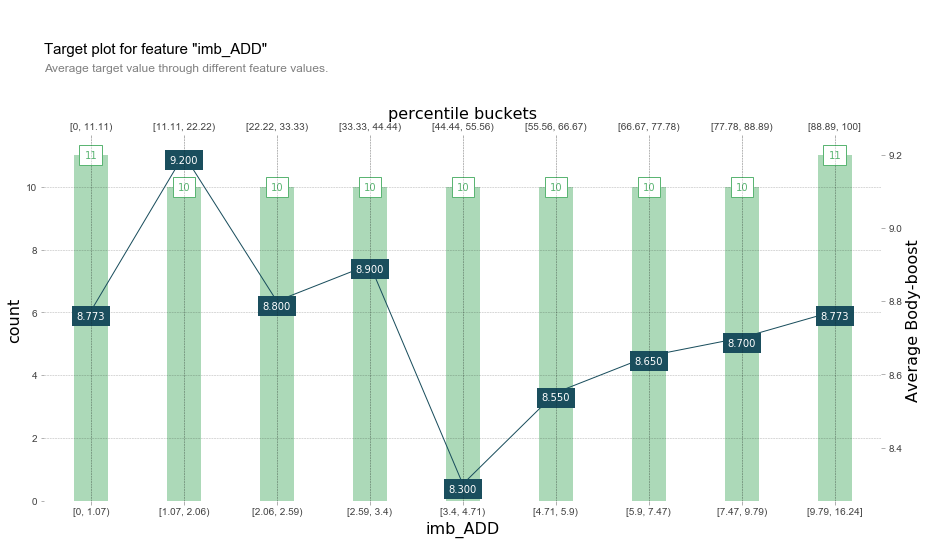

In [148]:
fig, axes, summary_df = info_plots.target_plot(
    df=df_pdp,
    feature=feature,
    feature_name=feature,
    target=target,
    show_percentile=True)

In [149]:
summary_df

,x,display_column,value_lower,value_upper,percentile_column,percentile_lower,percentile_upper,count,Body-boost
0,0,"[0, 1.07)",0.000000,1.068004,"[0, 11.11)",0.00,11.11,11,8.772727
1,1,"[1.07, 2.06)",1.068004,2.055630,"[11.11, 22.22)",11.11,22.22,10,9.200000
2,2,"[2.06, 2.59)",2.055630,2.592750,"[22.22, 33.33)",22.22,33.33,10,8.800000
3,3,"[2.59, 3.4)",2.592750,3.403494,"[33.33, 44.44)",33.33,44.44,10,8.900000
4,4,"[3.4, 4.71)",3.403494,4.706636,"[44.44, 55.56)",44.44,55.56,10,8.300000
5,5,"[4.71, 5.9)",4.706636,5.901453,"[55.56, 66.67)",55.56,66.67,10,8.550000
6,6,"[5.9, 7.47)",5.901453,7.466664,"[66.67, 77.78)",66.67,77.78,10,8.650000
7,7,"[7.47, 9.79)",7.466664,9.788655,"[77.78, 88.89)",77.78,88.89,10,8.700000
8,8,"[9.79, 16.24]",9.788655,16.242144,"[88.89, 100]",88.89,100.00,11,8.772727


### pdp for feature 'ADD'

In [150]:
def plot_pdp(model, dataset, model_feature, feature, clusters=None):
    p = pdp.pdp_isolate(model, dataset, model_feature, feature)
    return pdp.pdp_plot(
        p,
        feature,
        plot_lines=True,
        cluster=clusters is not None,
        n_cluster_centers=clusters)

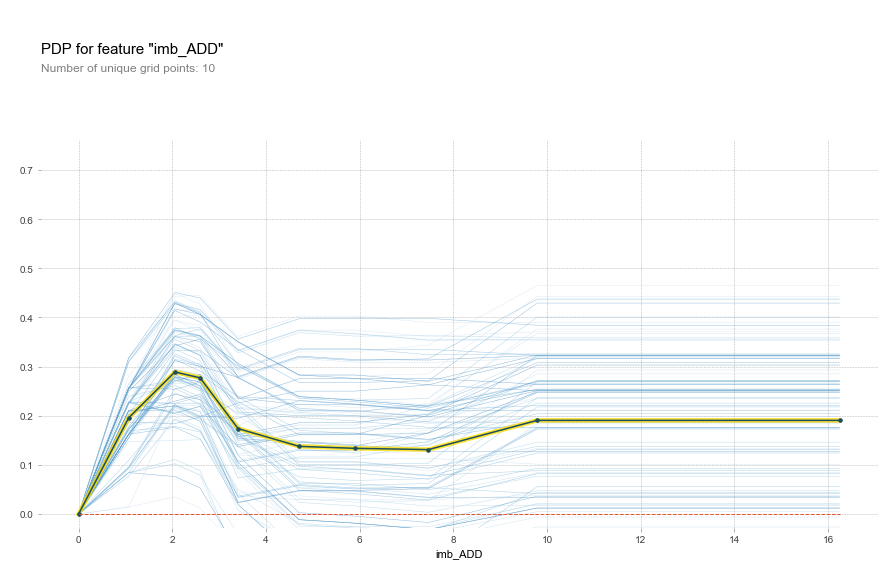

In [152]:
df_pdp = X_augmented.copy()
df_pdp[target] = y[target]

plot_pdp(
    model=boosted[target],
    dataset=df_pdp,
    model_feature=X_augmented.columns,
    feature=feature);

---

In [158]:
def augment_X(X):
    X_augmented = pd.DataFrame()
    for name, icol in X.iteritems():
        b = np.empty(0)
        if name[-1] == 'G':
            a = icol
        else:
            b = icol
        if b.any():
            X_augmented[name[:-2]] = f_score(a, b)
            X_augmented[f'imb_{name[:-2]}'] = imbalance(a, b)

    X_augmented['Height'] = df['Height']
    X_augmented['Weight'] = df['Weight']
    return X_augmented

In [304]:
targets

['Body-boost', 'Egg-beater max height', 'Egg-beater max force']

In [67]:
from sklearn.linear_model import LinearRegression


linear_model = LinearRegression()
linear_model.fit(X_train, y_train[target])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [68]:
participant = 42
target = 'Egg-beater max height'
force_initial = X.iloc[[participant]]
row = augment_X(force_initial)
model = linear_model
score_initial = model.predict(row)

In [69]:
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import Bounds # a voir si nécessaire ... pour considérer aussi les baisses de force
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint

In [70]:
# minimax
def f_cost(x):
    return x[-1]


def f_der(x):
    x = np.zeros(12)
    return np.append(x, 1)  #pas certain


def f_hess(x):
    return np.zeros(13)


# minimize sum augmentation
def f2_cost(x):
    return x.sum()


def f2_der(x):
    return np.ones(12)


def cons_f(x):
    newrow = x[:-1] + force_initial
    row = augment_X(newrow)
    return model.predict(row)


def cons_f2(x):
    newrow = x + force_initial
    row = augment_X(newrow)
    return model.predict(row)


def cons_f3(x):
    newrow = x + force_initial
    row = augment_X(newrow)
    return model.predict(row) - score_initial - 0.5

In [71]:
# n_predictor = 12
# n_x = n_predictor + 1
# x0 = np.ones(n_x) * 0.1

# A = -np.eye(n_predictor)
# A = np.c_[A, np.ones(n_predictor)]

# b_l = np.zeros(n_predictor)
# b_u = np.ones(n_predictor) * np.inf

# bounds = Bounds(np.zeros(n_x), np.ones(n_x) * np.inf)

# linear_constraint = LinearConstraint(A, b_l, b_u)
# nonlinear_constraint = NonlinearConstraint(
#     cons_f, score_initial + 0.5, score_initial + 0.5, jac='2-point')

# res = minimize(
#     f_cost,
#     x0,
#     method='trust-constr',
#     jac=f_der,
#     hess=f_hess,
#     constraints=[linear_constraint, nonlinear_constraint],
#     bounds=bounds,
#     options={'verbose': 1})

n_x = n_predictor
x0 = np.ones(n_x) * 0.1

bounds = Bounds(np.zeros(n_x), np.ones(n_x) * np.inf)

nonlinear_constraint2 = NonlinearConstraint(
    cons_f2, score_initial + 0.5, score_initial + 0.5, jac='3-point')

res = minimize(
    f2_cost,
    x0,
    method='trust-constr',
    jac=f2_der,
    hess='cs',
    constraints=nonlinear_constraint2,
    bounds=bounds
)

# c = {
#     'type': 'eq',
#     'fun': cons_f3,
# }

# res = minimize(
#     f2_cost,
#     x0,
#     method='SLSQP',
#     jac=f2_der,
#     constraints=c,
#     options={'verbose': 1})

In [72]:
model.coef_

array([ 0.017901  , -0.00747553, -0.04765204,  0.00758218,  0.08993645,
        0.01228717,  0.0749572 ,  0.00225168, -0.02960827,  0.00315042,
        0.05515337, -0.00159624,  1.47294767, -0.00710058])

In [73]:
augment_X(force_initial)

,ADD,imb_ADD,ABD,imb_ABD,ER,imb_ER,IR,imb_IR,EXT,imb_EXT,FLEX,imb_FLEX,Height,Weight
42,21.425466,8.389013,16.492467,1.494396,7.098009,25.76,9.445572,4.016913,18.670724,13.004826,12.439405,7.671125,1.6,48.99


In [75]:
augment_X(force_initial + res.x)

,ADD,imb_ADD,ABD,imb_ABD,ER,imb_ER,IR,imb_IR,EXT,imb_EXT,FLEX,imb_FLEX,Height,Weight
42,21.425536,8.388897,16.492525,1.494644,7.858041,60.889414,9.445604,4.017564,18.670783,13.004903,12.439411,7.671048,1.6,48.99


In [76]:
model.predict(augment_X(force_initial))

array([8.58321397])

In [78]:
model.predict(augment_X(force_initial + res.x))

array([9.08321397])

In [340]:
res.x

array([6.01095640e-01, 3.49853541e-03, 2.51916249e-01, 7.26793589e-03,
       5.71257757e-04, 6.03700686e-01, 5.98640830e-01, 5.87630615e-01,
       5.98903265e-01, 5.61837934e-03, 5.22445458e-03, 5.99552749e-01,
       6.04326894e-01])

- if using xgboost: use another optimizer (bayesian?)
- try a "continuous model" but better than a linear regression
- try without imbalance

In [ ]:
res = minimize(
    f_cost,
    x0,
    method='trust-constr',
    jac=f_der,
    hess=f_hess,
    constraints=[linear_constraint, nonlinear_constraint],
    bounds=bounds,
    options={'verbose': 1})